## Simulation baseret på estimater angivet i artiklen

In [27]:
import random
import matplotlib.pyplot as plt
import pandas as pd
import os
import collections as cl
import numpy as np

# Read in tables with estimated parameters 
pe_df = pd.read_csv('treatment1_pe_params.csv')
p_df = pd.read_csv('treatment1_p_params.csv')
q_df = pd.read_csv('treatment1_q_params.csv')

# Subset to first experiment for now
grp_id = 1
pe_df = pe_df[pe_df["Group"] == grp_id]
p_df = p_df[p_df["Group"] == grp_id]
q_df = q_df[q_df["Group"] == grp_id]

# Tuples for holding individual parameters 
mp_pe = cl.namedtuple('mp_pe', ['c', 'alpha_1', 'alpha_2', 'alpha_3'])
mp_p = cl.namedtuple('mp_p', ['c', 'beta_1', 'beta_2', 'beta_3', 'beta_4'])
mp_q = cl.namedtuple('mp_q', ['c', 'gamma_1', 'gamma_2', 'gamma_3', 'gamma_4'])


In [29]:
# Markedsparametre

# Number of subjects with estimated parameters
num_agents = len(pe_df.index)

# Alpha: hvor meget forbrugere vil efterspørge, hvis prisen er nul
alpha = 10.5

# Beta: hældning på demand-kurve, hvor stor effekt prisen på varen har på efterspørgslen
beta = 1.75

# Theta: afgører hvilken indflydelse det har at prisen afviger fra markedsgennemsnittet
theta = 1.45833

# Market demand
def demand(price, market_price):
    return alpha - beta * price + theta * market_price

# Common model parameters for all agents
mp_all = {'endowment': 500, 'mc': 8}


In [30]:
# Agent class
class Producer:
    def __init__(self, initial_price, initial_production, mp_all, mp_pe, mp_p, mp_q):
        # Initiale værdier
        self.price = initial_price
        self.price_t1 = initial_price
        self.price_t2 = initial_price
        
        self.market_price_forecast = self.price
        self.quantity = initial_production
        self.excess_supply = 0
        
        self.profit = 0
        self.profit_t1 = 0
        self.profit_t2 = 0
        self.PI_t1 = 0

        # Normalfordelte konstanter (det står ikke i paperet hvordan de er sat)
        # self.epsilon = random.gauss(0, 0.01)
        # self.u = random.gauss(0, 0.01)
        # self.eta = random.gauss(0, 0.01)
        self.epsilon = 0
        self.u = 0
        self.eta = 0

        # Koefficienter for agenten baseret på estimater
        self.mp_pe = mp_pe
        self.mp_p = mp_p
        self.mp_q = mp_q
        
        # Marginal produktionsomkostning
        self.mc = mp_all['mc']
        
        # Balance is set to intial endowment
        self.balance = mp_all['endowment']
        self.bankrupt = False

    def set_price(self, market_price_t1, market_price_t2):
        
        if (self.bankrupt):
            self.price = np.nan
            return None
        
        # Forudsig indeværende periodes gennemsnitlige pris
        self.market_price_forecast = (self.mp_pe.c 
                                      + self.mp_pe.alpha_1 * market_price_t1
                                      + self.mp_pe.alpha_2 * self.market_price_forecast
                                      + self.mp_pe.alpha_3 * market_price_t2
                                      + self.epsilon)

        # Opdater historiske priser
        self.price_t2 = self.price_t1
        self.price_t1 = self.price
        
        # Sæt vores pris denne periode
        self.price = (self.mp_p.c 
                      + self.mp_p.beta_1 * self.price
                      + self.mp_p.beta_2 * self.market_price_forecast
                      + self.mp_p.beta_3 * self.PI_t1
                      + self.mp_p.beta_4 * self.excess_supply
                      + self.u)

    def set_production_level(self):
        
        if (self.bankrupt):
            self.quantity = np.nan
            return None
        
        # Baseret på prædikteret efterspørgsel
        demand = (self.mp_q.c
                  + self.mp_q.gamma_1 * self.quantity
                  + self.mp_q.gamma_2 * self.price
                  + self.mp_q.gamma_3 * self.market_price_forecast
                  + self.mp_q.gamma_4 * self.excess_supply
                  + self.eta)

        # Producer den mængde der efterspørges
        self.quantity = max(demand, 0)

    def observe_demand(self, demand):        
        
        if (self.bankrupt):
            self.excess_supply = np.nan
            return None
        
        # Opdater overskud i varer (hvor meget blev ikke solgt)
        self.excess_supply = max(self.quantity - demand, 0)
    
    def observe_profit(self, demand):
        
        if (self.bankrupt):
            self.profit = np.nan
            return None
        
        # Opdater historisk profit
        self.profit_t2 = self.profit_t1
        self.profit_t1 = self.profit
        
        # Beregn profit i denne periode
        self.profit = self.price*demand - self.mc*self.quantity
        
        # Opdater balance
        self.balance += self.profit
        
        # Update bankruptcy state
        self.bankrupt = (self.balance < 0)
    
    def observe_PI(self):
        
        if (self.bankrupt):
            self.PI_t1 = np.nan
            return None
        
        # Ændringer i profit og pris i forrige periode
        self.PI_t1 = (self.price_t1 - self.price_t2) * sign(self.profit_t1 - self.profit_t2)
        
# Helper functions
def sign(x):
    if (x < 0):
        return -1
    else: 
        return 1

In [31]:
# ---------------------------------------------------------    
# Opret agenterne
# ---------------------------------------------------------
iterations = 100 # Antal iterationer
mean_production_list = [7.5] * 3 # Alle agenter producerer lige meget før simulationen starter
mean_price_list = [11] * 3 # Alle agenter har sat samme pris i perioderne før simulationen starter
mean_profit_list = [0] * 3 # Gennemsnitlig profit

# Opret agenterne
agents = []
for i in range(num_agents):
    
    ipe = pe_df.loc[i, ['c', 'p_t1', 'p_dif', 'pe_t1']]
    ip = p_df.loc[i, ['c', 'p_t1', 'pe_t', 'diff_pi_p', 'S_t1']]
    iq = q_df.loc[i, ['c', 'q_t1', 'p_t', 'pe_t', 'S_t1']]
    
    imp_pe = mp_pe(c = ipe.c,
                alpha_1 = ipe.p_t1,
                alpha_2 = ipe.p_dif,
                alpha_3 = ipe.pe_t1)
    
    imp_p = mp_p(c = ip.c,
                beta_1 = ip.p_t1,
                beta_2 = ip.pe_t,
                beta_3 = ip.diff_pi_p,
                beta_4 = ip.S_t1)
    
    imp_q = mp_q(c = iq.c,
                gamma_1 = iq.q_t1,
                gamma_2 = iq.p_t,
                gamma_3 = iq.pe_t,
                gamma_4 = iq.S_t1)
    
    agent = Producer(mean_price_list[-1], mean_production_list[-1], mp_all, imp_pe, imp_p, imp_q)
    agents.append(agent)

# Create data frames containing each agent's choices
cols = ["agent" + str(i) for i in range(num_agents)]

price_df = pd.DataFrame(np.nan, index = range(iterations), columns = cols)
quantity_df = pd.DataFrame(np.nan, index = range(iterations), columns = cols)
profit_df = pd.DataFrame(np.nan, index = range(iterations), columns = cols)

# Helper functions
def get_attr(agents, attr):
    x = []
    for agent in agents:
        x.append(getattr(agent, attr))
    return x

In [32]:
# -------------------------------------------------------------
# Kør simulationen
# -------------------------------------------------------------
for t in range(iterations):
    # Lad agenterne sætte pris og produktionsniveau
    for agent in agents:
        agent.set_price(mean_price_list[-1], mean_price_list[-2])
        agent.set_production_level()

    # Beregn markedspris og gennemsnitlig produktion
    prices_t = get_attr(agents, "price")
    price_df.loc[t] = prices_t    
    mean_price_t = np.nanmean(prices_t)

    quantities_t = get_attr(agents, "quantity")
    quantity_df.loc[t] = quantities_t    
    mean_production_t = np.nanmean(quantities_t)
    
    # Lad agenter observere faktisk efterspørgsel
    for agent in agents:
        d = demand(agent.price, mean_price_t)
        agent.observe_demand(d)
        agent.observe_profit(d)
        agent.observe_PI()
    
    profits_t = get_attr(agents, "profit")
    profit_df.loc[t] = profits_t
    mean_profit_t = np.nanmean(profits_t)

    # Gem markedspris og gns. produktion til plot
    mean_price_list.append(mean_price_t)
    mean_production_list.append(mean_production_t)
    mean_profit_list.append(mean_profit_t)


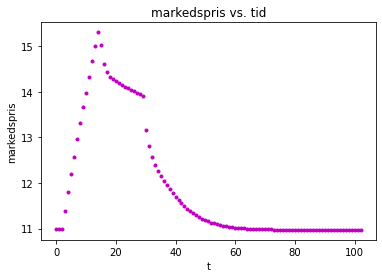

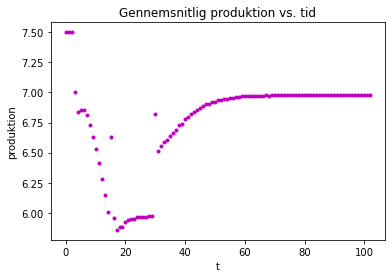

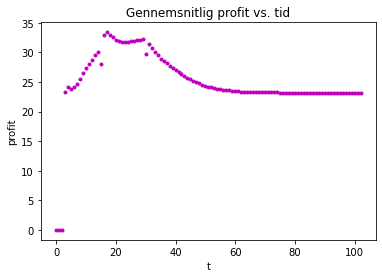

In [33]:
# Print resultater
# for t in range(iterations):
    # print(t, market_price_list[t], production_averages[t])

# Plot markedspris
plt.title('markedspris vs. tid')
plt.xlabel('t')
plt.ylabel('markedspris')
plt.plot(range(iterations+3), mean_price_list, 'm.')
plt.show()

# Plot produktion
plt.title('Gennemsnitlig produktion vs. tid')
plt.xlabel('t')
plt.ylabel('produktion')
plt.plot(range(iterations+3), mean_production_list, 'm.')
plt.show()


# Plot profit
plt.title('Gennemsnitlig profit vs. tid')
plt.xlabel('t')
plt.ylabel('profit')
plt.plot(range(iterations+3), mean_profit_list, 'm.')
plt.show()


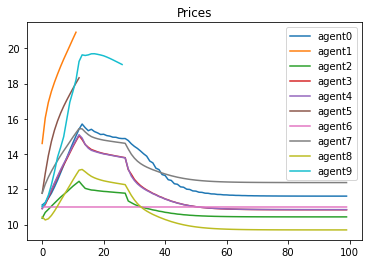

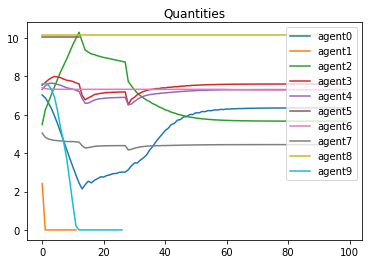

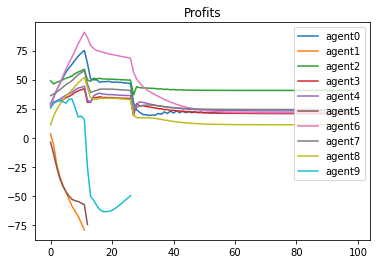

In [34]:
# Visualize how each agent is doing
price_df.plot();
plt.title("Prices");
plt.legend(loc = "upper right");

quantity_df.plot()
plt.title("Quantities")
plt.legend(loc = "upper right");

profit_df.plot();
plt.title("Profits");
plt.legend(loc = "upper right");